Formula 1

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt


# 1 Gather Data
We want to...

In [26]:
data_dir_path = "../data/"
# Read the csv files
results = pd.read_csv(data_dir_path + "results.csv", na_values=np.nan)
driver_standings = pd.read_csv(data_dir_path + "driver_standings.csv", na_values=np.nan)
constructor_standings = pd.read_csv(
    data_dir_path + "constructor_standings.csv", na_values=np.nan
)
raceYears = pd.read_csv(data_dir_path + "races.csv", na_values=np.nan)
names = pd.read_csv(data_dir_path + "drivers.csv", na_values=np.nan)

# Filter columns
raceYears = raceYears[["raceId", "year"]]
# raceYears = raceYears[raceYears["year"] >= 2010]  # Only data after 2010
results = results[["raceId", "driverId", "constructorId", "grid", "position"]]
driver_standings = driver_standings[["raceId", "driverId", "position"]]
constructor_standings = constructor_standings[["raceId", "constructorId", "position"]]
names = names[["driverId", "driverRef"]]

# rename because other csv also have position
driver_standings = driver_standings.rename(columns={"position": "driverStanding"})
constructor_standings = constructor_standings.rename(
    columns={"position": "constructorStanding"}
)

year_driver_standing = pd.merge(raceYears, driver_standings, on=["raceId"], how="inner")

results_driver_standings = pd.merge(
    results, year_driver_standing, on=["raceId", "driverId"], how="inner"
)

joined_data = pd.merge(
    results_driver_standings,
    constructor_standings,
    on=["raceId", "constructorId"],
    how="inner",
)

joined_data = pd.merge(joined_data, names, on=["driverId"], how="inner")
joined_data.drop(columns=["raceId", "constructorId", "driverId"], inplace=True)
joined_data.replace(to_replace="\\N", value=20, inplace=True)
joined_data["position"] = joined_data["position"].astype(int)

# Drop year before calculating the mean for every driver
joined_data.drop("year", axis=1)

X = joined_data[["grid", "driverStanding", "constructorStanding"]]
Y = joined_data[["position"]]


# Divide by train data and test data
# train_data = joined_data.loc[joined_data["year"] <= 2000]
# test_data = joined_data.loc[joined_data["year"] > 2000]
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)


# Calculate mean values for every driver
# train_data = train_data.groupby(["driverRef"]).mean()
# test_data = test_data.groupby(["driverRef"]).mean()

# X_train = train_data[["grid", "driverStanding", "constructorStanding"]]
# Y_train = train_data[["position"]]

# X_test = train_data[["grid", "driverStanding", "constructorStanding"]]
# Y_test = train_data[["position"]]


In [27]:
def edit_Y(y, regression=True):
    """Edits Y to be 1 or not 1 for regression or not regression.

    Notes:
        Pandas DF is passed by reference, so no returns.

    Args:
        y (pd.DataFrame): Dataframe with column position
        regression (bool, optional): True if regression, false for others.
    """
    y.loc[(y["position"] != 1) & (y["position"] != 2) & (y["position"] != 3)] = (
        0 if regression else -1
    )


In [28]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

edit_Y(Y_train, regression=True)
edit_Y(Y_test, regression=True)

Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

Y_train = Y_train.reshape(Y_train.shape[0])
Y_test = Y_test.reshape(Y_test.shape[0])


# 2 Standardise and Scale

In [29]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# 3A Logistic Regression

In [30]:
def polynomial_logistic_regression(X_train, Y_train, X_test, Y_test, max_degree=6):
    """Polynomial logistic regression

    Args:
        X_train (np.array): Training data
        Y_train (np.array): Training labels
        X_test (np.array): Testing data
        Y_test (np.array): Testing labels
    """
    logreg = LogisticRegression(multi_class="multinomial", max_iter=10_000)
    training_error, testing_error = [], []

    print("Polynomial Logistic Regression Score")
    print("Degree \t Test Score \t Train Score")
    for i in range(1, max_degree + 1):
        # Init polynomial features
        poly = PolynomialFeatures(degree=i)

        # Polynomial fit of training data
        X_train_poly = poly.fit_transform(X_train)

        # Train model
        logreg.fit(X_train_poly, Y_train)

        # Polynomial fit of test data
        X_test_poly = poly.fit_transform(X_test)

        # Get scores
        training_score = logreg.score(X_train_poly, Y_train)
        testing_score = logreg.score(X_test_poly, Y_test)

        # Append errors
        training_error.append(1 - training_score)
        testing_error.append(1 - testing_score)

        # Fancy print B)
        print(f"{i} \t {testing_score*100.0:.2f}% \t {training_score*100.0:.2f}%")

    return training_error, testing_error


In [31]:
def plot_error(training_error, testing_error):
    """Plots the training and testing error.

    Args:
        training_error (list): List of training errors
        testing_error (list): List of testing errors
    """
    plt.plot(training_error, label="Training Error")
    plt.plot(testing_error, label="Testing Error")
    plt.xticks(np.arange(len(testing_error)), np.arange(1, len(testing_error) + 1))
    plt.xlabel("Degree")
    plt.ylabel("Error")
    plt.legend()
    plt.show()


In [32]:
training_error, testing_error = polynomial_logistic_regression(
    X_train, Y_train, X_test, Y_test, max_degree=7
)


Polynomial Logistic Regression Score
Degree 	 Test Score 	 Train Score
1 	 88.71% 	 88.40%
2 	 88.76% 	 88.41%
3 	 88.84% 	 88.36%
4 	 88.73% 	 88.40%
5 	 88.69% 	 88.42%
6 	 88.57% 	 88.44%
7 	 88.50% 	 88.58%


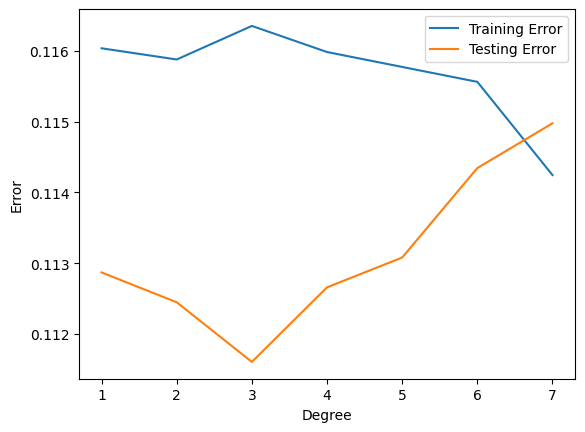

In [34]:
plot_error(training_error, testing_error)


# 3B SVM

In [10]:
# svmachine = SVC(kernel='rbf', C=1E6)
# svmachine.fit(X_train, Y_train)
# svmachine.score(X_train, Y_train)


In [13]:
# svmachine.score(X_test, Y_test)
svmachine2 = SVC(kernel="poly", degree=7)
svmachine2.fit(X_train, Y_train)
svmachine2.score(X_train, Y_train)
svmachine2.score(X_test, Y_test)


0.8776065276518585

In [35]:
def polynomial_svm(X_train, Y_train, X_test, Y_test, max_degree=6):
    """Polynomial Support Vector Machine

    Args:
        X_train (np.array): Training data
        Y_train (np.array): Training labels
        X_test (np.array): Testing data
        Y_test (np.array): Testing labels
    """
    training_error, testing_error = [], []

    print("Polynomial SVM Score")
    print("Degree \t Test Score \t Train Score")
    for i in range(1, max_degree + 1):
        svmachine = SVC(kernel="poly", degree=i)

        # Init polynomial features
        poly = PolynomialFeatures(degree=i)

        # Polynomial fit of training data
        X_train_poly = poly.fit_transform(X_train)

        X_test_poly = poly.fit_transform(X_test)

        svmachine.fit(X_train_poly, Y_train)
        # Get scores
        training_score = svmachine.score(X_train_poly, Y_train)
        testing_score = svmachine.score(X_test_poly, Y_test)

        # Append errors
        training_error.append(1 - training_score)
        testing_error.append(1 - testing_score)

        # Fancy print B)
        print(f"{i} \t {testing_score*100.0:.2f}% \t {training_score*100.0:.2f}%")

    return training_error, testing_error


In [36]:
training_error, testing_error = polynomial_svm(
    X_train, Y_train, X_test, Y_test, max_degree=7
)


Polynomial SVM Score
Degree 	 Test Score 	 Train Score
1 	 88.69% 	 88.28%
2 	 88.86% 	 88.36%
3 	 88.61% 	 88.25%
4 	 87.57% 	 87.09%
5 	 87.57% 	 87.09%
6 	 87.57% 	 87.09%
7 	 87.57% 	 87.09%


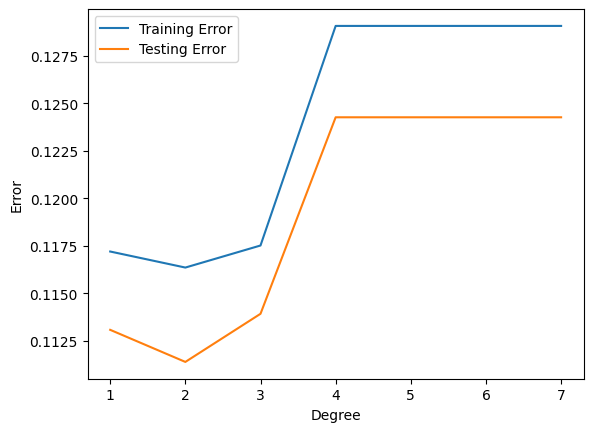

In [37]:
plot_error(training_error, testing_error)
